Launch the Docker with the appropriate ports exposed:
`$ docker run -p 8000:8000 -it --gpus all --shm-size=20g synthefy/external:stage_e2`

Launch the backend inside the Docker Container:
`# python3 examples/launch_backend.py --config examples/configs/api_configs/api_config_infovista_halo.yaml`

In [7]:
%matplotlib inline

import pandas as pd
import httpx
import json
from io import StringIO
import matplotlib.pyplot as plt
from anomaly_detection_utils import plot_anomaly_windows, plot_concurrent_anomalies, save_anomaly_results, plot_group_anomalies, AnomalyMetadata, convert_json_to_anomaly_detection_format, load_anomaly_results, plot_concurrent_group_anomalies
import os
from datetime import datetime
import tempfile
from loguru import logger


In [8]:
client = httpx.Client(base_url="http://localhost:8000", timeout=3600.0)

## Load data and config


In [9]:
# SYNTHEFY_PACKAGE_BASE - path to the synthefy package folder
SYNTHEFY_PACKAGE_BASE = "/home/ubuntu/code/synthefy-package"
# SYNTHEFY_DATASETS_BASE - path to the datasets folder
SYNTHEFY_DATASETS_BASE = "/home/ubuntu/data"
# DATASET_NAME - name of the dataset folder
DATASET_NAME = "infovista_halo"

config_path = f"{SYNTHEFY_PACKAGE_BASE}/examples/configs/preprocessing_configs/config_{DATASET_NAME}_preprocessing.json"
preprocess_config = json.load(open(config_path))

df = pd.read_parquet(
    f"{SYNTHEFY_DATASETS_BASE}/{DATASET_NAME}/{preprocess_config['filename'].split('/')[-1]}",
    engine="pyarrow",
)


timestamps_col = preprocess_config["timestamps_col"]
group_labels_cols = preprocess_config["group_labels"]["cols"]
timeseries_cols = preprocess_config["timeseries"]["cols"]
frequency_type = preprocess_config["anomaly_detection"]["frequency"]["type"]

required_cols = (
    timestamps_col + group_labels_cols + timeseries_cols
)
df = df[required_cols]
df[timestamps_col[0]] = df[timestamps_col[0]].astype(str)

In [10]:
stream_synthesis_response = client.post(
    f"/api/v2/anomaly_detection/{DATASET_NAME}/stream",
    json=json.loads(df.to_json()),
)

In [11]:
results, concurrent_results = convert_json_to_anomaly_detection_format(stream_synthesis_response)

In [12]:
df[timestamps_col[0]] = pd.to_datetime(df[timestamps_col[0]])

## Save anomaly results

In [13]:
results_filename = f"anomaly_detection_results_10ch_1x"

In [14]:
output_filename, output_filename_concurrent = save_anomaly_results(results, concurrent_results, f"{SYNTHEFY_DATASETS_BASE}/{DATASET_NAME}", results_filename)

2025-01-19 00:45:28.497 | INFO     | anomaly_detection_utils:save_anomaly_results:522 - Saved anomaly detection results to: /Users/bekzatajan/Synthefy/projects/datasets/infovista_halo/anomaly_detection_results_10ch_1x.json
2025-01-19 00:45:29.218 | INFO     | anomaly_detection_utils:save_anomaly_results:527 - Saved concurrent anomaly results to: /Users/bekzatajan/Synthefy/projects/datasets/infovista_halo/anomaly_detection_results_10ch_1x_concurrent.json


## Load the saved results using filename if necessary

In [15]:
load_file = True
if load_file:
    load_path = os.path.join(f"{SYNTHEFY_DATASETS_BASE}/{DATASET_NAME}", results_filename)
    print(f"Loading from {load_path}")
    results, concurrent_results = load_anomaly_results(load_path)

Loading from /Users/bekzatajan/Synthefy/projects/datasets/infovista_halo/anomaly_detection_results_10ch_1x


## Plot anomalies for the group
- anomaly_type: choose from ["peak", "scattered", "out_of_pattern", "mixed"]
- group_name: choose from the group_labels_cols (if multiple group labels joined by "-")

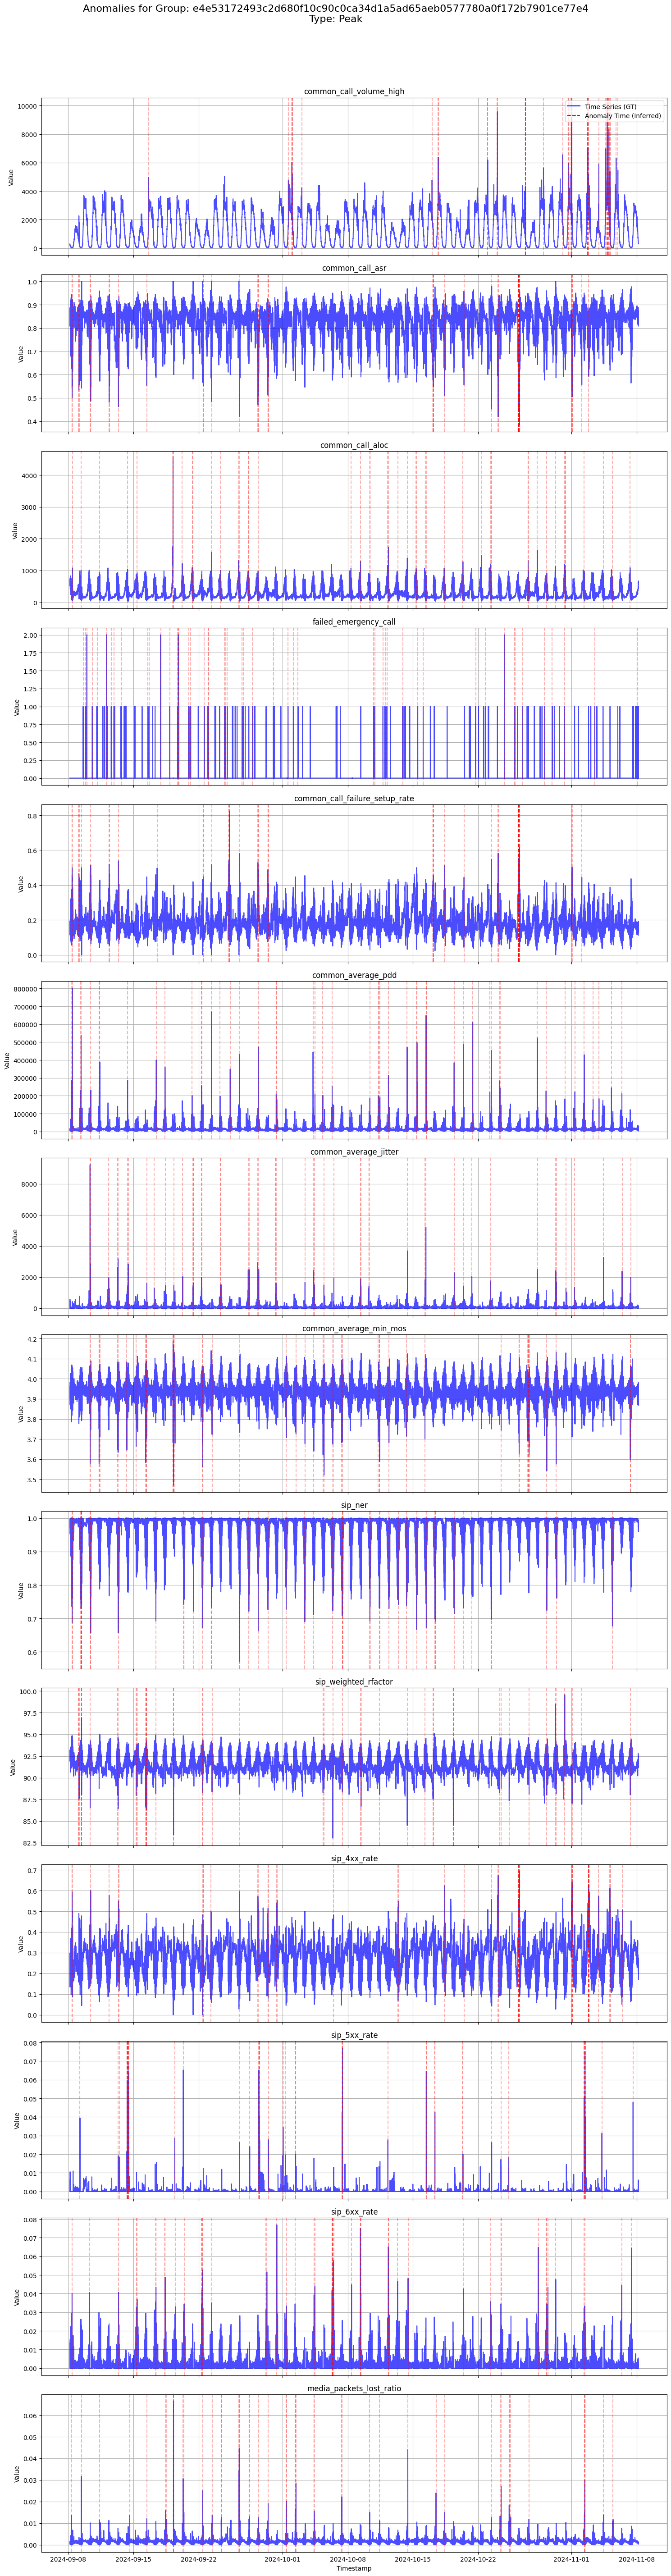

In [16]:
plot_group_anomalies(df, results=results, all_kpis = timeseries_cols, anomaly_type="peak", group_name="e4e53172493c2d680f10c90c0ca34d1a5ad65aeb0577780a0f172b7901ce77e4", timestamps_col=timestamps_col)

## List all anomaly groups

In [17]:
results["sip_5xx_rate"]["peak"].keys()

dict_keys(['07af577ed5961da5b98dc3e73f004dc2032ca9d321ac1c8746fd583d88021652', '0e65857494a839667bc79c259ab70db6d282ab5e71337200aa0bc7c9a427f8ca', '27546a10eb6d5588262b402b5116ec84f5a82c861b05fce2aac8ad4ddd2345d2', '2cf261997bbbe16e28031b2b4ebc45a59c00f9c91219f738db73b672ca0c53d7', '52cec0a27e2d7b664ccb840cd74592067f8066d695ee392dc136c82529826e97', '9329a702394989b60cb97581447e3160db34461b7c4176a0f0017888e5bed491', 'e41ce5165c7be9c8186b621a0e9ed4d7f32964ca0688ecd8966be1180c7961c4', 'e4e53172493c2d680f10c90c0ca34d1a5ad65aeb0577780a0f172b7901ce77e4'])

## Plot Concurrent Anomalies (All Types)

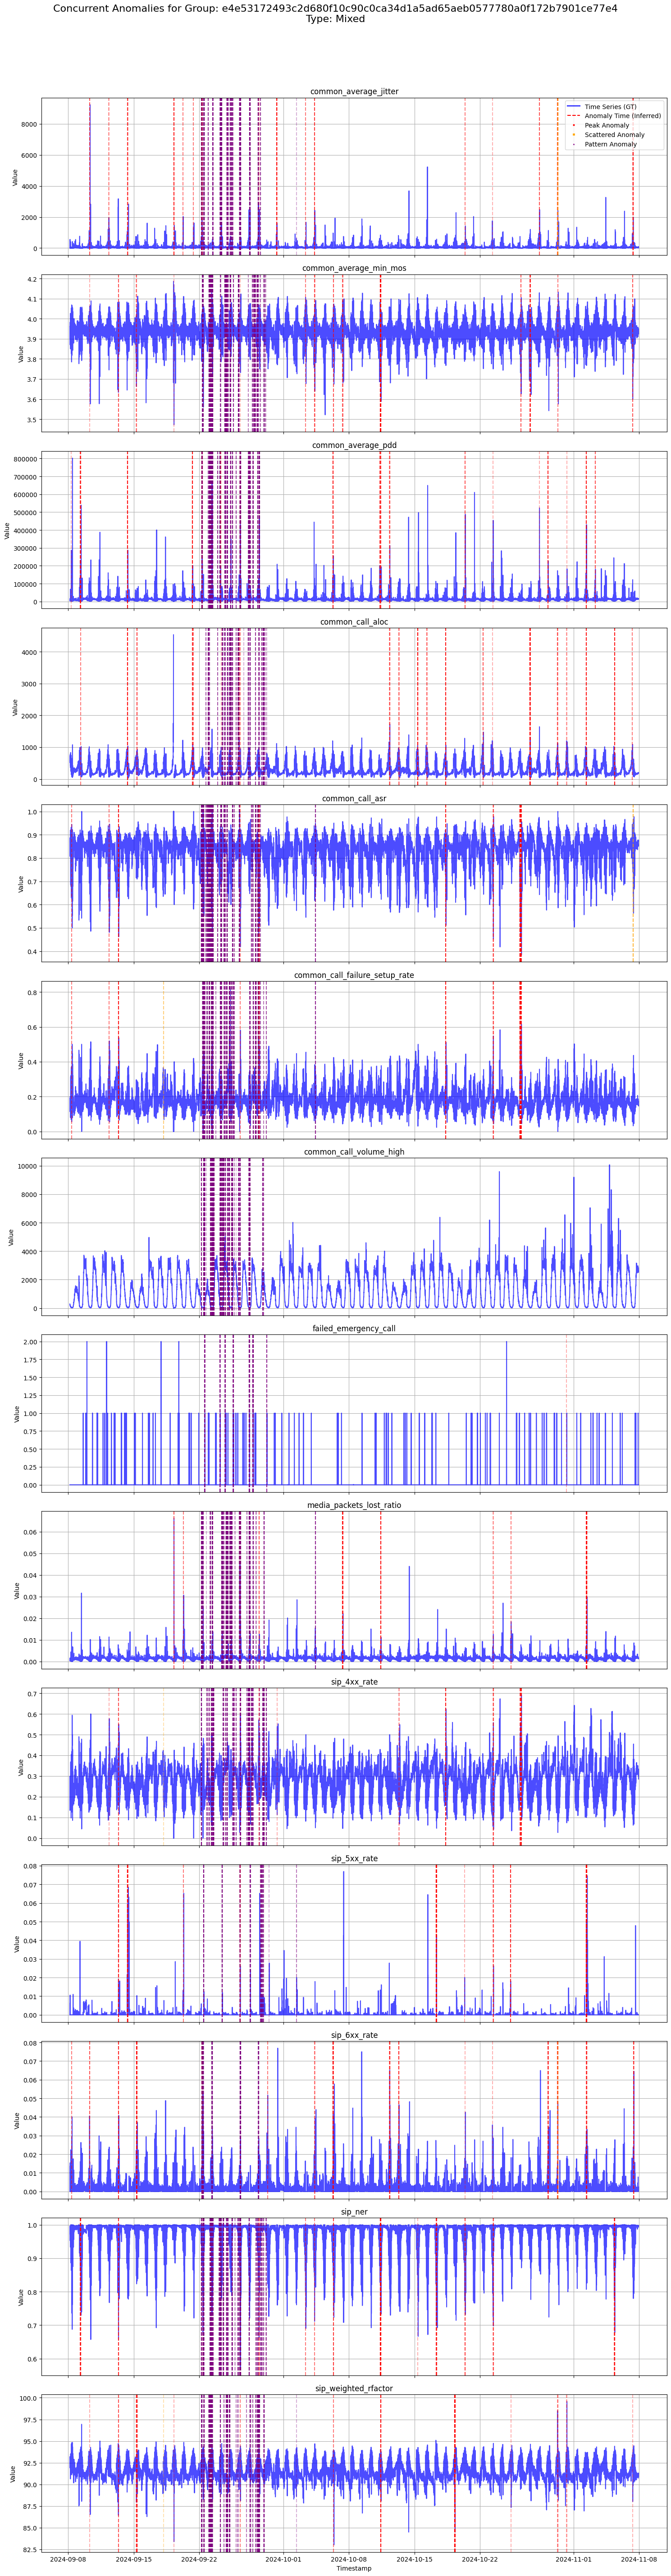

In [18]:
plot_concurrent_group_anomalies(df, concurrent_results=concurrent_results, group_name="e4e53172493c2d680f10c90c0ca34d1a5ad65aeb0577780a0f172b7901ce77e4", anomaly_type="mixed", timestamps_col=timestamps_col)

## Plot Concurrent Anomalies (Peak Only)

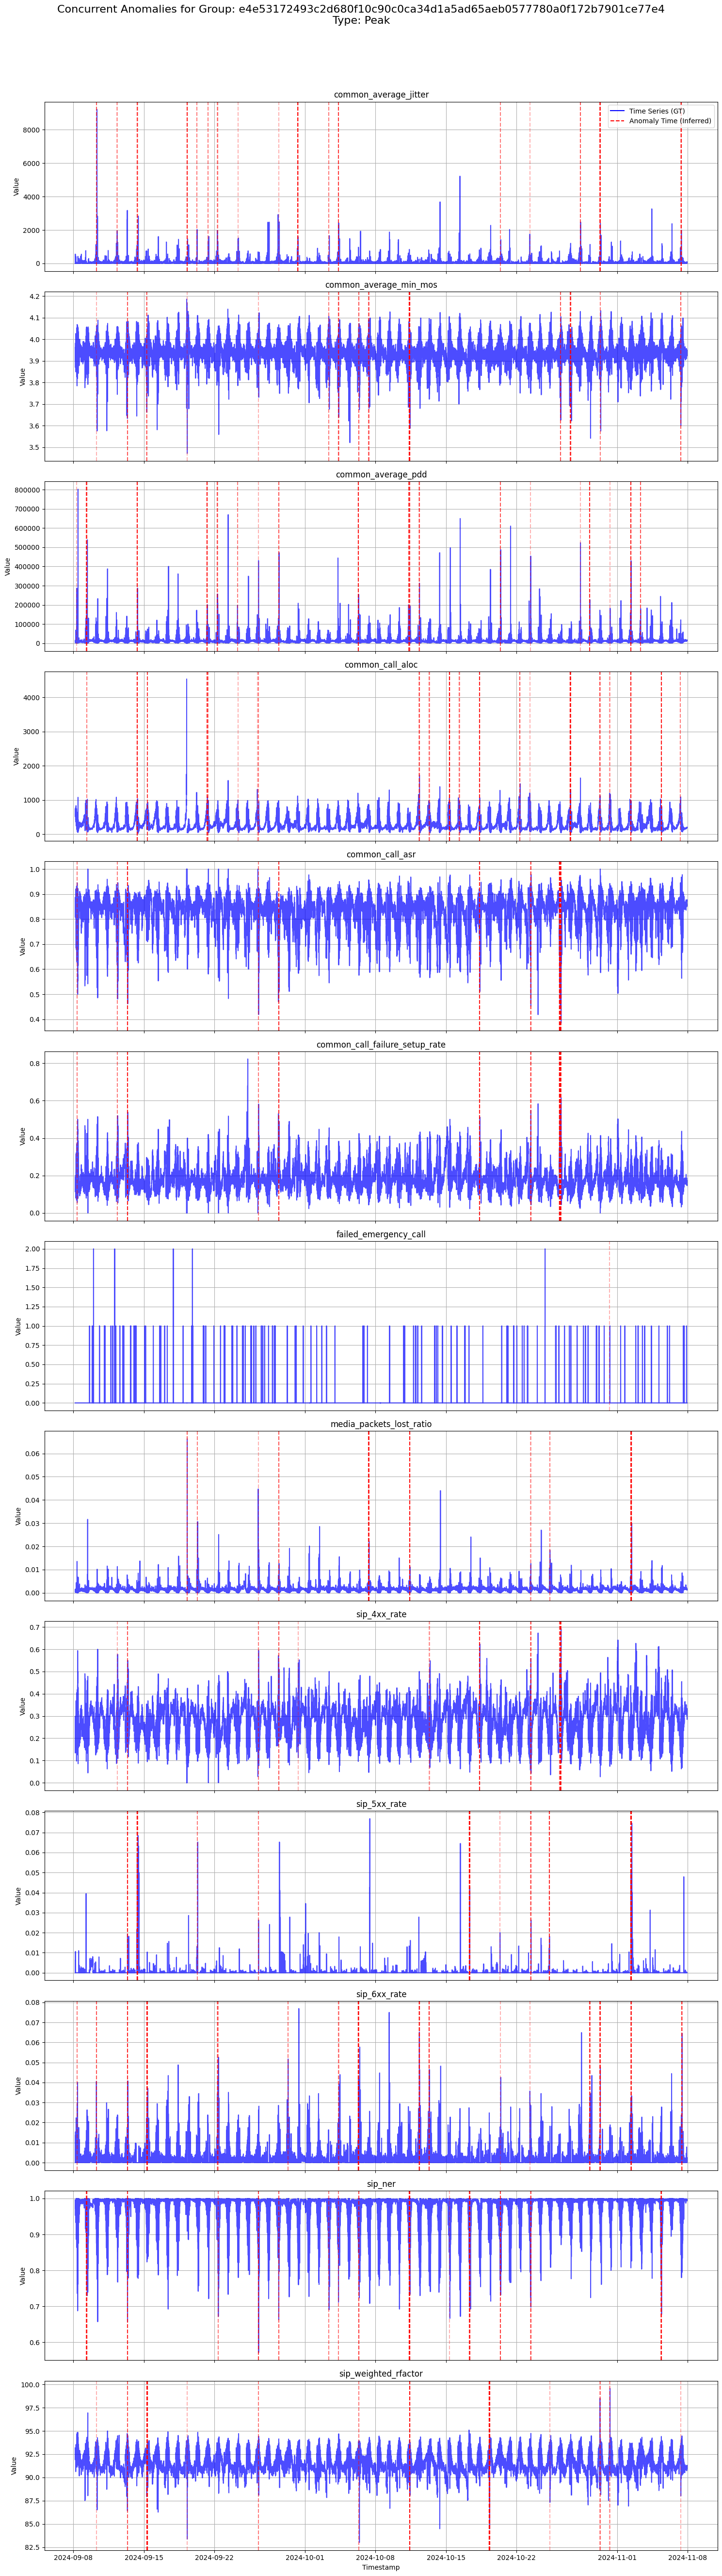

In [19]:
plot_concurrent_group_anomalies(df, concurrent_results=concurrent_results, group_name="e4e53172493c2d680f10c90c0ca34d1a5ad65aeb0577780a0f172b7901ce77e4", anomaly_type="peak", timestamps_col=timestamps_col)